<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/Value%20Based/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
from matplotlib import pyplot as plt
from itertools import count
import tempfile
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

# DQN

DQN stands for "Deep Q-network". It uses a target network and a replay buffer. By using target network, we make the targets appear stationary to the optimizer, which is good for stability, albeit by sacrificing convergence speed.
By using a replay buffer, the online data looks more independent and identically distributed, which is a source of significant issues in value-based bootstrapping methods. These two techniques combined make the algorithm sufficiently stable for performing well in several deep reinforcement learning tasks.


# Q Network

We create a fully connected neural network which will approximate the Q function. Given a batch of states as input, it outputs a batch of Q-values. Each Q-value represents the return we can expect when we take a particular action in the given state.

In [24]:
class QNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):
    super(QNetwork, self).__init__()
    self.activation_fc = activation_fc

    # input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    # hidden layer(s)
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    # output layer
    self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    # check the device type
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state):
    '''
    Format the state.
    '''
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)

    return x

  def forward(self, state):
    '''
    Apply the forward pass
    '''
    # format the input which is state in our case
    x = self._format(state)
    # pass formatted state through the input layer
    x = self.activation_fc(self.input_layer(x))
    # pass the output of the input through the hidden layer(s)
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    # pass output of hidden layer(s) through the output layer
    x = self.output_layer(x)
    return x

  def numpy_float_to_device(self, variable):
    variable = torch.from_numpy(variable).float().to(self.device)
    return variable

  def load(self, experiences):
    states, actions, rewards, new_states, is_terminals = experiences
    states = torch.from_numpy(states).float().to(self.device)
    actions = torch.from_numpy(actions).long().to(self.device)
    new_states = torch.from_numpy(new_states).float().to(self.device)
    rewards = torch.from_numpy(rewards).float().to(self.device)
    is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    return states, actions, rewards, new_states, is_terminals

# Replay Buffer

The replay buffer is a data structure that allows us to implement a technique called **experience replay**. It holds experience samples for several timesteps so that we can sample mini-batches of experiences.

The main benefit of using a replay buffer: the samples (experiences) we pass to the network appear independent and identically distributed which in turn stabilize the optimization process.

The idea behind experience replay is very straightforward:
During training, we collect experiences and store them into the replay buffer. After enough experiences are collected, we then sample a mini-batch of a certain size from the buffer and pass it to the network.

In [25]:
class ReplayBuffer():
  # our replay buffer has a default max size of 50000 and uses a batch size of 64
  def __init__(self, max_size=10000,
               batch_size=64):

    # initialize five empty NumPy arrays that will hold states, actions, rewards, next_states and done flags
    self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

    self.max_size = max_size
    self.batch_size = batch_size
    self._idx = 0
    self.size = 0

  def store(self, experience):
    '''
    Store the components of the experience into the corresponding NumPy array.
    '''
    # unwrap the experience which is just a tuple
    s, a, r, p, d = experience

    # store each component to its corresponding NumPy array
    self.ss_mem[self._idx] = s
    self.as_mem[self._idx] = a
    self.rs_mem[self._idx] = r
    self.ps_mem[self._idx] = p
    self.ds_mem[self._idx] = d

    # adjust the index
    self._idx += 1

    # if the replay buffer is full, we wrap around and overwrite older experiences with new ones
    self._idx = self._idx % self.max_size

    # adjust the size
    self.size += 1
    # determine the size
    self.size = min(self.size, self.max_size)

  def sample(self, batch_size=None):
    '''
    Sample a mini-batch of experiences from the replay buffer.
    '''
    if batch_size == None:
      batch_size = self.batch_size

    # Generate a uniform random sample from np.arange(self.size) of size 'batch_size' without replacement:
    idxs = np.random.choice(self.size, batch_size, replace=False)

    # create the mini-batch of experiences
    mini_batch_experiences = np.vstack(self.ss_mem[idxs]), \
                             np.vstack(self.as_mem[idxs]), \
                             np.vstack(self.rs_mem[idxs]), \
                             np.vstack(self.ps_mem[idxs]), \
                             np.vstack(self.ds_mem[idxs])

    return mini_batch_experiences

  def __len__(self):
    return self.size

# Exploration Strategies

In DQN, we use exploration strategies based on Q-values. We get the values of actions in a given state using the learned Q-function and explore based on those values.

The GreedyStrategy will always select the maximum Q-value.

In [26]:
# the strategy we will use in the evaluation phase
class GreedyStrategy():

  def select_action(self, model, state):
    with torch.no_grad():
      # get the q-value of each action given the state
      q_values = model(state).cpu().detach().data.numpy().squeeze()

      # return the index of the action with the highest estimate
      return np.argmax(q_values)

The exponential $\epsilon$-greedy strategy a decaying epsilon value so that the probability of exploration is higher at the beginning and the probability of exploitation is higher at the end of the training phase.

In [27]:
# the strategy we will use in the training phase
class EGreedyExpStrategy():
  '''
  In the exponentially decaying strategy, the epsilon value is decaying in an exponential curve.
  '''

  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.decay_steps = decay_steps
    self.min_epsilon = min_epsilon
    self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
    self.t = 0

  def _epsilon_update(self):
    self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
    self.t += 1

    return self.epsilon

  def select_action(self, model, state):

    with torch.no_grad():
      # pass the state to the online model to get the Q values
      q_values = model(state).detach().cpu().data.numpy().squeeze()

    # we draw the random number from a uniform distribution and compare it to epsilon
    # if it is higher, we use the argmax of the q-values
    # otherwise, we use a random action
    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    # adjust the epsilon value
    self._epsilon_update()

    return action

# DQN agent

In this section, the DQN agent will start learning how to act in the CartPole environment. Note that agents such as DQN only work in discrete action-space environments, such as the cart-pole.

In the training process, the DQN agent collects experiences in an online manner and stores these online experience samples into a replay buffer. On every step, the agent pulls out a mini-batch from the replay buffer that is commonly sampled uniformly at random. The agent then uses this mini-batch to calculate a bootstrapped TD target and train a Q-function.

At the interaction step, we interact with the environment by taking a selected **action** within the environment. The action is selected based on our chosen training strategy (in this case: **EGreedyExpStrategy**). The resulting infos such as **new_state**, **reward**, etc. will then be used to form an experience.

Finally, that **experience** is then stored into the **replay buffer**. At the end, we also make updates to global variables (but those are not relevant for understanding the DQN algorithm; those are just for the statistics). And that's it.

At this step, we optimize the model using the following formula:

$\nabla_{\theta_{i}} L_{i} (\theta_{i}) = \mathbb{E}_{\underbrace{(s, a, r, s') \sim U(D)}_\text{sampling of experiences}}[ \underbrace{(r + \gamma \max_{a'} Q(s', a'; \theta^-)}_\text{Target} - \underbrace{Q(s, a; \theta_{i})}_\text{Prediction}) \nabla_{\theta_{i}}Q(s, a; \theta_{i})]$

Here are the components of the formula:

*   $\mathbb{E}_{(s, a, r, s') \sim U(D)}$

    we use the expectations of the experience tuples; we obtain the experiences we use for training by sampling uniformly at random the replay buffer D
*   $r$

    the experienced reward we get when we take a particular action $a$ in state $s$
*   $\gamma \max_{a'} Q(s', a'; \theta^-)$

    The discount factor $\gamma$ is used to discount the value of the action $a'$ with the highest estimate at the next state $s'$
    $\theta^-$ indicates that the target network will be used to query the Q-value estimates of the next state $s'$; after obtaining those, we select the maximum Q-value estimate

*   $r + \gamma \max_{a'} Q(s', a'; \theta^-)$

    This forms the Q-value target, also referred to as the off-policy TD target.
    In RL, there no are no real "true" values we could use as targets like in supervised learning. Therefore, our targets are predicted values themselves because they come from a network (in this case, from a target network)

*   $Q(s, a; \theta_{i})$

    This part forms the Q-value predictions; we pass the current state to the online network and get the Q-values estimates for each action $a$ in the state $s$

*   $\nabla_{\theta_{i}}Q(s, a; \theta_{i})$

    Indicates that we should apply backpropagation only to the online network $\theta_{i}$ during the training the training process.


We also have to update the weights of the target network with the weights of the online network in a peridodic manner.

The evaluation step is optional. At this step, we evaluate the given model.

In [28]:
gamma = 1.0
update_steps = 10
max_minutes = 20
max_episodes = 10000
goal_mean_100_reward = 475
warmup_batches = 5
lr = 0.0005
evaluation_scores = []

best_online_model = None
best_eval_score = float('-inf')
seeds = (12, 34, 56, 78, 90)

In [29]:
for seed in seeds:
  # create the CartPole environment with a unique seed
  env = gym.make("CartPole-v1")
  env.seed(seed)
  # create the replay buffer
  replay_buffer = ReplayBuffer(max_size=50000, batch_size=64)
  # set the training strategy
  training_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
  # set the evaluation strategy
  evaluation_strategy = GreedyStrategy()
  # define the state space
  state_space = env.observation_space.shape[0]
  # define the action space
  action_space = env.action_space.n
  # create the online model
  online_model = QNetwork(state_space, action_space, hidden_dims=(512,128))
  # create the target model
  target_model = QNetwork(state_space, action_space, hidden_dims=(512,128))
  # create the optimizer
  optimizer = optim.RMSprop(online_model.parameters(), lr=lr)
  # get the starting time of the training
  training_start = time.time()

  # UPDATE step
  # make sure that online and target network have the same weights before training
  for target, online in zip(target_model.parameters(), online_model.parameters()):
    target.data.copy_(online.data)    # copy weights into the target network

  # for each episode
  for episode in range(max_episodes):
    cur_state = env.reset()    # get the initial state
    is_terminal = False        # flag indicating whether episode is finished or not
    episode_timestep = 0   # initialize list to hold the number of timesteps

    # for each timestep in the current episode
    for timestep in count():

      # INTERACTION step
      # select an action according to the exponentially decaying epsilon-greedy exploration strategy
      action = training_strategy.select_action(online_model, cur_state)

      # perform the selected action in the environment
      new_state, reward, is_terminal, info = env.step(action)

      # determine if CartPole's built-in TimeLimit is reached
      is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

      # calculate the is_failure flag indicating a terminal state
      is_failure = is_terminal and not is_truncated

      # create the experience
      experience = (cur_state, action, reward, new_state, float(is_failure))

      # store the experience into the replay buffer
      replay_buffer.store(experience)

      # adjust the timestep so that we know when to update the target network
      episode_timestep += 1

      # update current state
      cur_state = new_state

      # check if we have enough experiences in the replay buffer
      if len(replay_buffer) > replay_buffer.batch_size * warmup_batches:

        # OPTIMIZATION step
        # sample a mini-batch of experiences from the replay buffer
        experiences = replay_buffer.sample()

        # invoke the load() method which extracts the components of each experience
        # transforms them into a PyTorch tensor, and loads them onto the current device (cpu or gpu)
        experiences = online_model.load(experiences)

        # extract the experience components (batch of states, actions, etc.)
        states, actions, rewards, next_states, is_terminals = experiences

        # query the target network to get the Q-value estimates of the 'next_states'
        target_Q_values = target_model(next_states).detach()

        # from those Q-value estimates, select only the maximum Q-values
        max_target_Q_values = target_Q_values.max(dim=1)[0].unsqueeze(1)

        # now, we can build the target Q-values
        targets = rewards + (gamma * max_target_Q_values * (1 - is_terminals))

        # query the online network to get the Q-value estimates of 'states'
        online_Q_values = online_model(states)

        # since we are only interested in the Q-values of those actions
        # that were actually taken, we gather them by using the values
        # from the actions batch as index
        preds = online_Q_values.gather(dim=1, index=actions)

        # compute the value loss
        value_loss = (targets - preds).pow(2).mul(0.5).mean()

        # perform the standard backpropagation
        optimizer.zero_grad()
        value_loss.backward()
        optimizer.step()

      # update the weights of the target network periodically
      if episode_timestep % update_steps == 0:
        # UPDATE step
        # make sure that online and target network have the same weights
        for target, online in zip(target_model.parameters(), online_model.parameters()):
          target.data.copy_(online.data)    # copy weights into the target network

      # break if current state was a terminal state
      if is_terminal:
        break


    # EVALUATION step (optional)
    # compute the evaluation score
    rewards = []
    for _ in range(1):
      state = env.reset()
      is_terminal = False
      rewards.append(0)
      for _ in count():
        action = evaluation_strategy.select_action(online_model, state)
        state, reward, is_terminal, _ = env.step(action)
        rewards[-1] += reward
        if is_terminal:
          break

    # get the evaluation score
    evaluation_score = np.mean(rewards)
    # store the evaluation score
    evaluation_scores.append(evaluation_score)

    # comput the mean evaluation score
    mean_100_eval_score = np.mean(evaluation_scores[-100:])
    # determine the elapsed wallclock time
    wallclock_elapsed = time.time() - training_start
    # flag indicating whether max minutes is reached
    reached_max_minutes = wallclock_elapsed >= max_minutes * 60
    # flag indicating whether max episodes is reached
    reached_max_episodes = episode >= max_episodes
    # flag indicating whether mean goal reward is reached
    reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward

    # finish if one of the flags is true
    training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
    if training_is_over:
      if reached_max_minutes: print('Max minutes are reached')
      if reached_max_episodes: print('Max episodes are reached')
      if reached_goal_mean_reward: print('Goal mean reward is reached')
      break

  # EVALUATION step (optional)
  # compute final evaluation score
  rewards = []
  for _ in range(1):
    state = env.reset()
    is_terminal = False
    rewards.append(0)
    for _ in count():
      action = evaluation_strategy.select_action(online_model, state)
      state, reward, is_terminal, _ = env.step(action)
      rewards[-1] += reward
      if is_terminal:
        break

  # get the final evaluation score
  final_evaluation_score = np.mean(rewards)
  print(f"Final_evaluation score: {final_evaluation_score}")

  env.close()
  del env

  # check if current final evaluation score is better than the last best evaluation score
  if final_evaluation_score > best_eval_score:
    # save the final evaluation score
    best_eval_score = final_evaluation_score
    # save the current best online model
    best_online_model = online_model

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0


# Save the model

In [30]:
# save the online model
torch.save(best_online_model.state_dict(), "/content/drive/MyDrive/DQN/DQN_agent_final.pt")

# Load the model

In [31]:
env = gym.make("CartPole-v1")
model = QNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(512,128))
model.load_state_dict(torch.load("/content/drive/MyDrive/DQN/DQN_agent_final.pt"))
model.eval()

QNetwork(
  (input_layer): Linear(in_features=4, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
)

# Visualization

In [32]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [33]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):
      # get the Q-value estimates
      q_values = model(state)
      # select the action (greedily)
      action = np.argmax(q_values.data.numpy())

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode+1}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'DQN_agent.gif'), frames, fps=60)

In [34]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


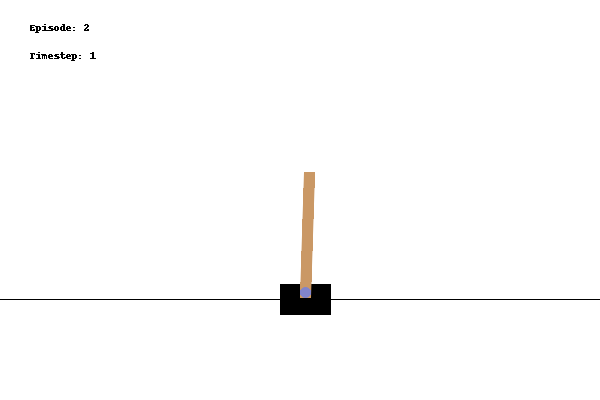

In [35]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Gif/DQN_agent.gif','rb').read())